In [ ]:
!pip install -q keras-ocr transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [ ]:
import os
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import keras_ocr
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
class H2DPipeline:
    def __init__(self,model_path):
        self.detector = keras_ocr.detection.Detector()
        self.processor = TrOCRProcessor.from_pretrained(model_path)
        self.model = VisionEncoderDecoderModel.from_pretrained(model_path)

    def __get_bounding_boxes_for_image(self, image_path):
       bboxes= self.detector.detect([image_path],link_threshold=0.4)
       return self.__sort_into_lines(bboxes[0])

    def __line_check(self, box1, box2):
        box1_y_start = min(box1[0,1],box1[1,1])
        box1_y_end = max(box1[2,1],box1[3,1])
        box2_y_start = min(box2[0,1],box2[1,1])
        box2_y_end = max(box2[2,1],box2[3,1])
        if((box2_y_start <= box1_y_end and box2_y_start >= box1_y_start)
        or(box2_y_end <= box1_y_end and box2_y_end >= box1_y_start)
        or(box2_y_end >= box1_y_end and box2_y_start <= box1_y_start)):
            return True
        else:
            return False

    def __sort_into_lines(self, bounding_boxes):
      line_groups = []
      line_index = 0
      skipped = []
      # fills a 2d array, line_groups
      #   1st dimension is each line
      #   2nd dimension is each word within that line
      for i in range(len(bounding_boxes)):
        if i in skipped:
          i = skipped[-1]+1
          continue
        line_groups.append([])
        line_groups[line_index].append(bounding_boxes[i])
        # print(f"i: {i} line_groups length: {len(line_groups)} skipped indexes: {skipped}")
        for j in range(i+1,len(bounding_boxes)):
          if self.__line_check(bounding_boxes[i],bounding_boxes[j]):
            line_groups[line_index].append(bounding_boxes[j])
            skipped.append(j)
        line_index += 1
      returnList = []
      # sorts each group by the lowest x value ie futherest to the left
      # then adds each word in the new order to returnList
      for line in line_groups:
        line.sort(key=lambda x: min(x[0][0],x[3][0]))
        for word in line:
          returnList.append(word)
      # converts the ordered list into a numpy array
      return np.array(returnList)

    def __cut_boxes_from_image(self, image_path):
        boxes = self.__get_bounding_boxes_for_image(image_path)

        image = Image.open(image_path).convert("RGB")
        imagesCorners = [[int(box[0][0]),int(box[0][1]),int(box[2][0]),int(box[2][1])] for box in boxes]
        images = [image.crop((box[0],box[1],box[2],box[3])) for box in imagesCorners]
        return images

    def __recongize_text(self, images):
        text_results =[]
        for img in images:
            pixel_values = self.processor(images=img, return_tensors="pt").pixel_values
            generated_ids = self.model.generate(pixel_values)
            generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            text_results.append(generated_text)
        return text_results

    def extract_text(self, image_path):
        images = self.__cut_boxes_from_image(image_path)
        text_results = self.__recongize_text(images)
        return text_results


In [ ]:
shared_folder_path = "/drive/MyDrive/"
model_path = os.path.join(shared_folder_path,"Comp 542/model/checkpoint-2750")

In [ ]:
pipeline = H2DPipeline(model_path)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

In [ ]:
image_path = "/drive/MyDrive/Comp 542/IAM/Outside Test Images/Rick roll.jpg"
print(image_path)


/drive/MyDrive/Comp 542/IAM/Outside Test Images/Rick roll.jpg


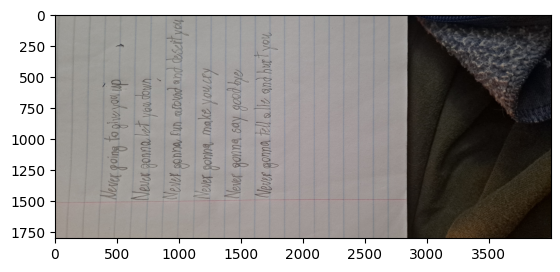

In [ ]:
image = Image.open(image_path).convert("RGB")

fig, ax = plt.subplots()
ax.imshow(image)

In [ ]:
pipeline = H2DPipeline(model_path)
print(pipeline.extract_text(image_path))

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step
["'s", "'s", ',', 'B.', ',', 'Is', "'s", '"', '&', 'I', 'I', 'I', '"', "'s", ',', 'B.', 'to', 'Is', 'is', "'s", 'is', 'I', '.', ',', "'s", ',', '"', '"', '"', '"', '"', '"', ',', '"']
